## AI-Powered Customer Purchase Analysis
## Product Recommendation
This notebook contains recommendation methods

This project is part of coding assignment for a position at BookedBy

Author @Suchit Singh Nagpal (sn3791@rit.edu)

Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

Data Load

In [2]:
data = pd.read_csv('data/customer_purchases3.csv')  

In [3]:
# Convert Purchase Date to datetime if necessary
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'])

# 1. Collaborative Filtering

Draws similarity of products using behaviour of similar customers


In [4]:
# Create a user-item matrix: rows are customers, columns are products
# aggregated on purchase amount
user_item_matrix = data.pivot_table(index='Customer ID', 
                                    columns='Product ID', 
                                    values='Purchase Amount', 
                                    aggfunc='sum',
                                    fill_value=0)

print("User-Item Matrix Shape:", user_item_matrix.shape)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_item_matrix.index, 
                                  columns=user_item_matrix.index)

User-Item Matrix Shape: (500, 50)


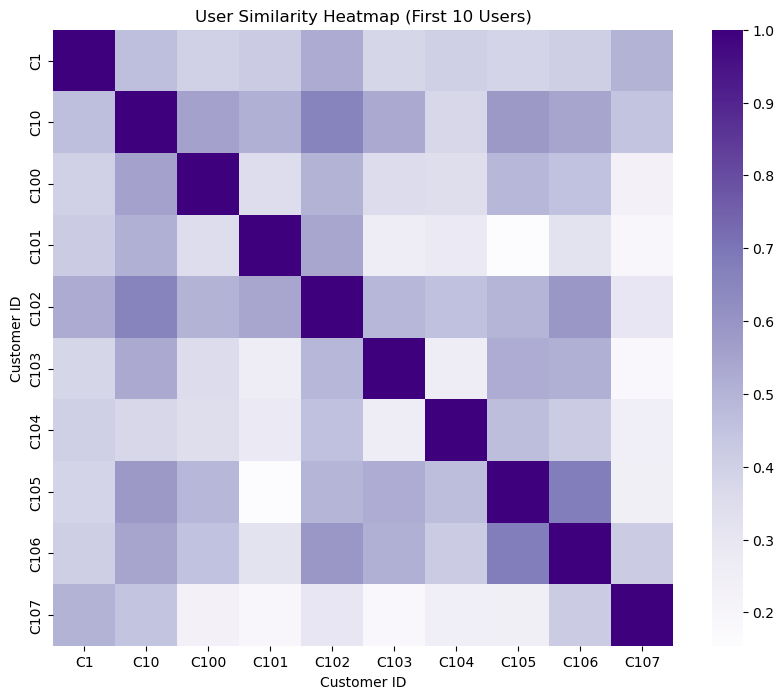

In [5]:
# Visualize a portion of the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df.iloc[:10, :10], cmap='Purples')
plt.title("User Similarity Heatmap (First 10 Users)")
plt.show()

Using behaviour of similar users

In [6]:
def recommend_products_collaborative(customer_id, top_n=5):
    # Get similar users (excluding the given customer)
    similar_users = user_similarity_df[customer_id].drop(customer_id).sort_values(ascending=False)
    
    # Weighted sum of purchases from similar users
    recommendation_scores = pd.Series(dtype=float)
    for other_customer, similarity in similar_users.items():  # Changed from iteritems() to items()
        # Only consider products not yet purchased by customer_id
        products_bought = user_item_matrix.loc[other_customer]
        # Multiply by similarity and add to scores
        recommendation_scores = recommendation_scores.add(products_bought * similarity, fill_value=0)
    
    # Remove products the customer already purchased
    products_already = user_item_matrix.loc[customer_id]
    recommendation_scores = recommendation_scores[products_already == 0]
    
    return recommendation_scores.sort_values(ascending=False).head(top_n)


Use Case: When a client adds one or more products to the cart

In [7]:
# Example recommendation for a sample customer
sample_customer = user_item_matrix.index[38]
print(f"Collaborative Recommendations for Customer {sample_customer}:")
print(recommend_products_collaborative(sample_customer))

Collaborative Recommendations for Customer C133:
Product ID
P9     38794.969494
P3     38231.392848
P4     36471.309049
P5     30952.823533
P43    28962.017826
dtype: float64


# 2. Content Based Filtering

Draws similarity between two products

Useful for neiche products with lesser data or interactions w users

In [8]:
# Create a product content DataFrame: For now, we use only 'Product Category'.
# We assume that each Product ID corresponds to one category.
product_content = data[['Product ID', 'Product Category']].drop_duplicates().set_index('Product ID')

# Use CountVectorizer to one-hot encode the Product Category 
# (even though it is a single word, this scales fields you have more text eg.product description)
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
# Since Product Category is not a sentence, we can treat it as a text field.
product_matrix = vectorizer.fit_transform(product_content['Product Category'])

# Compute cosine similarity between items (content-based)
content_similarity = cosine_similarity(product_matrix)
content_similarity_df = pd.DataFrame(content_similarity, 
                                     index=product_content.index, 
                                     columns=product_content.index)

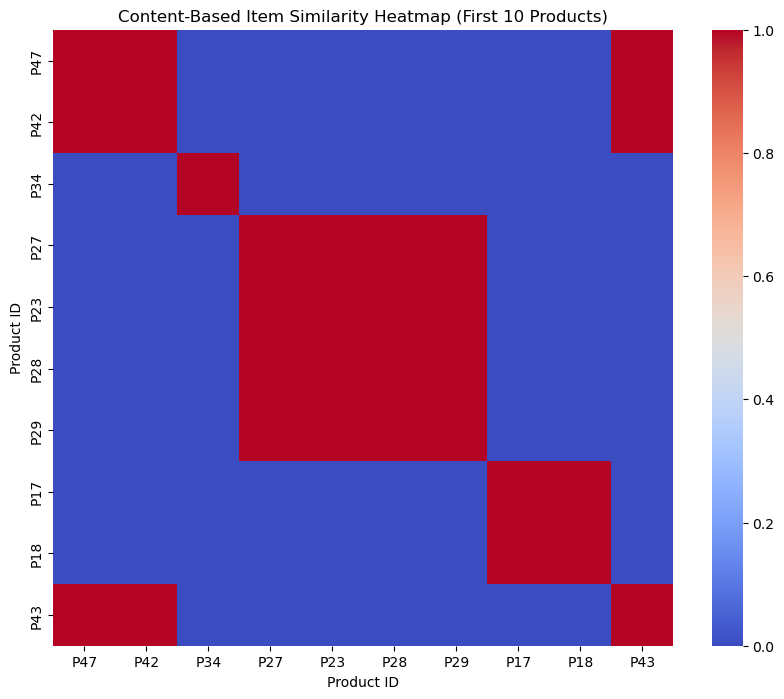

In [9]:

# Visualize a portion of the item–item content similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(content_similarity_df.iloc[:10, :10], cmap='coolwarm')
plt.title("Content-Based Item Similarity Heatmap (First 10 Products)")
plt.show()

In [10]:


# Function: Given a product, recommend similar products based on content
def recommend_products_content(product_id, top_n=7):
    if product_id not in content_similarity_df.index:
        return pd.Series(dtype=float)
    similar_products = content_similarity_df[product_id].drop(product_id).sort_values(ascending=False)
    return similar_products.head(top_n)

Content Based Filtering recommends on basis of similarity of product attributes like rating, review, searches and clicks. Since that additional data is not available, this form of filtering is not very relevant since it is only computed on purchase at this point.

Use Case: Search, or recommend similar items to current product

In [11]:
# Example recommendation for a sample product
sample_product = product_content.index[17]
print(f"Content-Based Recommendations for Product {sample_product}:")
print(recommend_products_content(sample_product))


Content-Based Recommendations for Product P45:
Product ID
P47    1.0
P43    1.0
P42    1.0
P50    1.0
P48    1.0
P44    1.0
P49    1.0
Name: P45, dtype: float64


# 3. Item Based Collabarative Filtering

Draws similarities between items 

Similarity derived on basis purchase patterns (historic) 

eg. Customer essentials or frequently bought items

In [12]:
# Create an item-user matrix (transpose of the user_item_matrix)
item_user_matrix = user_item_matrix.T

# Compute cosine similarity between items based on purchase patterns
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, 
                                  index=item_user_matrix.index, 
                                  columns=item_user_matrix.index)

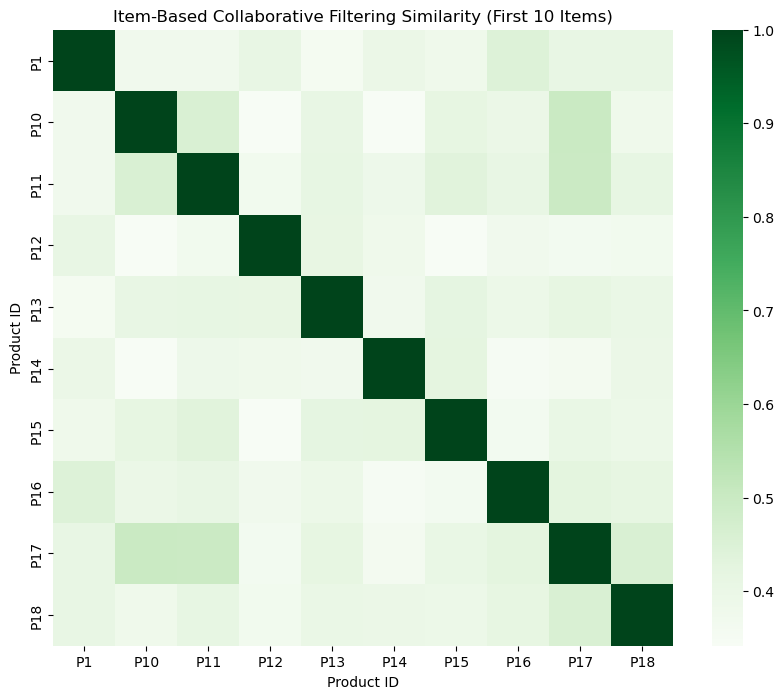

In [13]:
# Visualize a portion of the item similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(item_similarity_df.iloc[:10, :10], cmap='Greens')
plt.title("Item-Based Collaborative Filtering Similarity (First 10 Items)")
plt.show()

In [14]:
# Function: Given a product, recommend similar products based on item similarity
def recommend_products_item_based(product_id, top_n=5):
    if product_id not in item_similarity_df.index:
        return pd.Series(dtype=float)
    similar_items = item_similarity_df[product_id].drop(product_id).sort_values(ascending=False)
    return similar_items.head(top_n)


Use Case: Start of an order (empty cart) or while checkout (you forgot your essentials)

In [15]:

# Example recommendation for a sample product using item-based filtering
print(f"Item-Based Recommendations for Product {sample_product}:")
print(recommend_products_item_based(sample_product))


Item-Based Recommendations for Product P45:
Product ID
P32    0.471827
P17    0.451141
P3     0.445878
P9     0.441234
P50    0.433998
Name: P45, dtype: float64


# Hybrid Filtering

Combines customer historic behaviour as well as similar products

In [16]:
# For the content score, we average the similarity between a candidate product and all products
# that the customer has previously purchased.
def recommend_products_hybrid(customer_id, top_n=5, alpha=0.5):
    # alpha is the weight given to collaborative score (and 1-alpha to content score)
    
    # Collaborative scores
    collab_scores = recommend_products_collaborative(customer_id, top_n=50)  # get a larger set
    
    # Get products already purchased by the customer
    purchased_products = user_item_matrix.loc[customer_id]
    purchased_products = purchased_products[purchased_products > 0].index.tolist()
    
    # Compute a content score for each candidate product:
    # Average content similarity with products the customer has purchased.
    content_scores = {}
    for product in collab_scores.index:
        if product not in content_similarity_df.index:
            continue
        # For each product purchased by the customer, get similarity score to candidate product.
        sims = []
        for purchased in purchased_products:
            if purchased in content_similarity_df.index:
                sims.append(content_similarity_df.loc[product, purchased])
        # Average similarity score (if any)
        if sims:
            content_scores[product] = np.mean(sims)
        else:
            content_scores[product] = 0
    
    content_scores = pd.Series(content_scores)
    
    # Combine the two scores: here a simple weighted sum.
    hybrid_scores = alpha * collab_scores + (1 - alpha) * content_scores
    
    return hybrid_scores.sort_values(ascending=False).head(top_n)

Benefit: Give more holistic recommendation

In [17]:
print(f"Hybrid Recommendations for Customer {sample_customer}:")
print(recommend_products_hybrid(sample_customer))


Hybrid Recommendations for Customer C133:
Product ID
P9     19397.604747
P3     19115.816424
P4     18235.774524
P5     15476.531767
P43    14481.088913
dtype: float64


Compare Results from all 4 methods

In [18]:
# Suppose user_item_matrix is already defined as in your previous steps.
# For content-based and item-based recommendations, pick the customer's most purchased product.
def get_most_purchased_product(customer_id):
    purchased_products = user_item_matrix.loc[customer_id]
    if (purchased_products > 0).sum() > 0:
        return purchased_products.idxmax()
    else:
        return None

# For a given customer, use the most purchased product as the seed for content-based recommendations.
def recommend_content_for_customer(customer_id, top_n=5):
    product_id = get_most_purchased_product(customer_id)
    if product_id is not None:
        return recommend_products_content(product_id, top_n=top_n)
    else:
        return pd.Series(dtype=float)

# Similarly for item-based recommendations:
def recommend_item_based_for_customer(customer_id, top_n=5):
    product_id = get_most_purchased_product(customer_id)
    if product_id is not None:
        return recommend_products_item_based(product_id, top_n=top_n)
    else:
        return pd.Series(dtype=float)


In [19]:
# Select a sample of users
sample_users = user_item_matrix.index[:20]

# Define a dictionary with method names and corresponding recommendation functions
# Note: The collaborative and hybrid functions take customer_id directly.
recommendation_methods = {
    'Collaborative': recommend_products_collaborative,
    'Hybrid': recommend_products_hybrid,
    'Content-Based': recommend_content_for_customer,
    'Item-Based': recommend_item_based_for_customer,
}

# For each user, get a set of recommended product IDs (we use top_n=5 recommendations)
results = {}  # key: user, value: dict with method->set(recommended product IDs)
for user in sample_users:
    user_results = {}
    for method_name, rec_func in recommendation_methods.items():
        recs = rec_func(user, top_n=5)
        # Convert recommendations (the index of the Series) into a set
        user_results[method_name] = set(recs.index)
    results[user] = user_results



In [20]:
#Print one user's recommendations to inspect
example_user = sample_users[19]
print(f"Recommendations for user {example_user}:")
for method, recs in results[example_user].items():
    print(f"  {method}: {recs}")


Recommendations for user C116:
  Collaborative: {'P48', 'P7', 'P3', 'P50', 'P9'}
  Hybrid: {'P48', 'P7', 'P3', 'P50', 'P9'}
  Content-Based: {'P2', 'P10', 'P9', 'P5', 'P1'}
  Item-Based: {'P23', 'P11', 'P17', 'P10', 'P5'}
